# Task 2

forecasting_dataset.csv is a file that contains pollution data for a city. 

Your task is to create a model that, when fed with columns co_gt, nhmc, c6h6, s2, nox, s3, no2, s4, s5, t, rh, ah, and level, predicts the value of y six hours later.

## Load all the needed libraries

In [1]:
# Add the current path to the running path in order to import functions
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# basic libs
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn

# preprocessing
# from . import keras_model
from keras_model import keras_model
from select_columns import select_columns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from split_train_test_val import split_train_test_val

# model
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
from sklearn.metrics import roc_curve, r2_score
from hpsklearn import HyperoptEstimator, any_classifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet


# for pipeline
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor


# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.callbacks import TensorBoard

# save model
from sklearn.externals import joblib

% matplotlib inline
rcParams['figure.figsize'] = 15, 6

Using TensorFlow backend.


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## EDA

In [3]:
df = pd.read_csv("../../data/forecasting_dataset.csv")
df.shape

(8421, 16)

In [4]:
df.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,10/13/2004,20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN
1,8/10/2004,3:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low
2,6/21/2004,8:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High
3,7/12/2004,12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High
4,12/14/2004,12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High


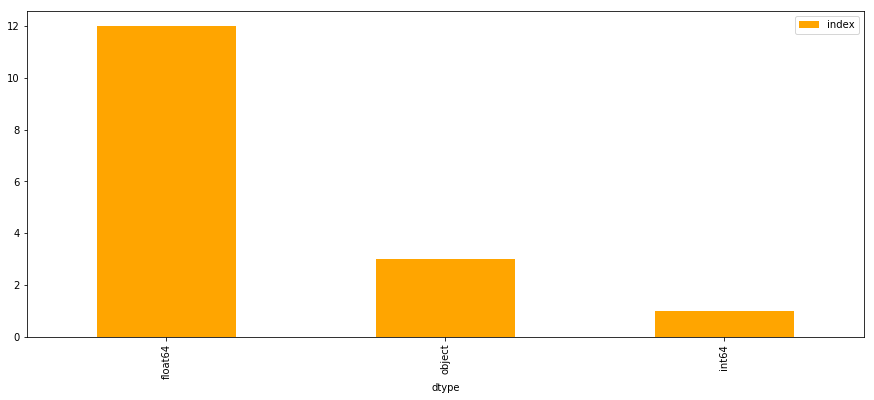

In [5]:
pd.DataFrame(df.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count().sort_values('index', ascending=False).plot(kind='bar', color="orange")

### Explore missing value pattern:
- Checking the missing pattern: Each white line is a missing value for that column
- Checking the missing number

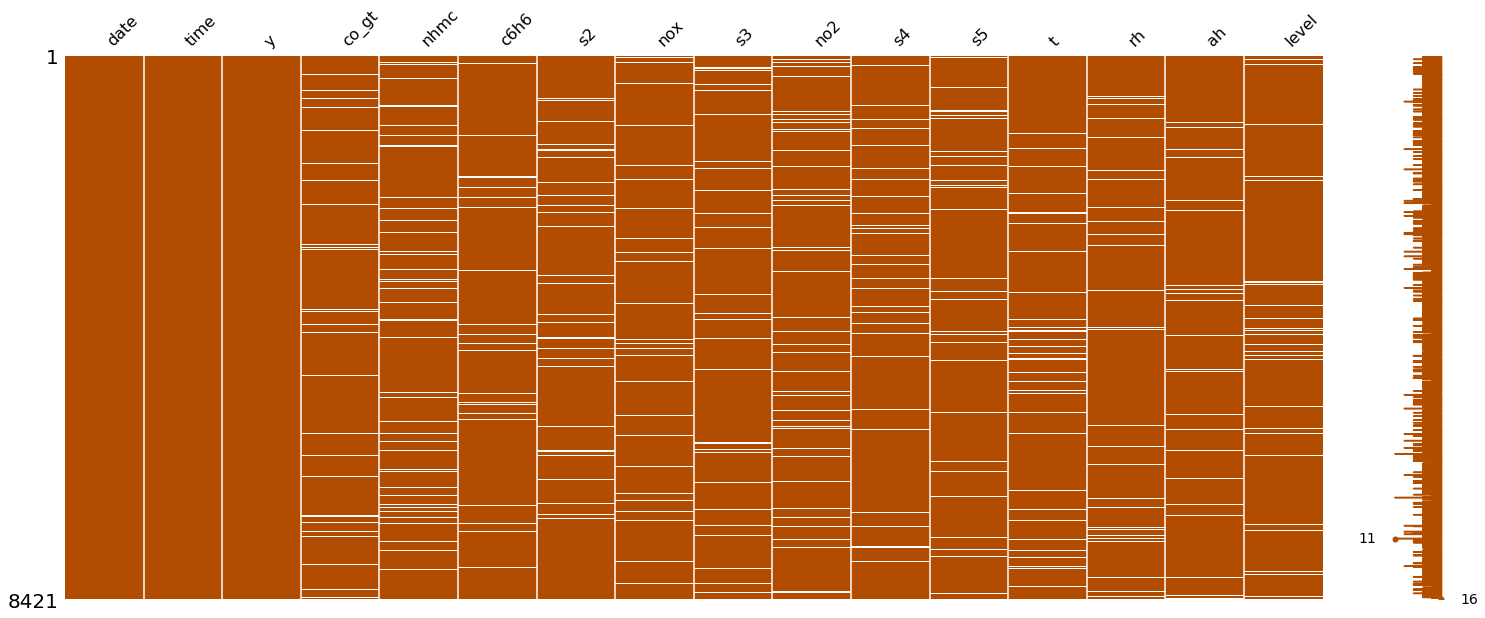

In [6]:
# Missing pattern
msn.matrix(df, color=(0.7, 0.3, 0))

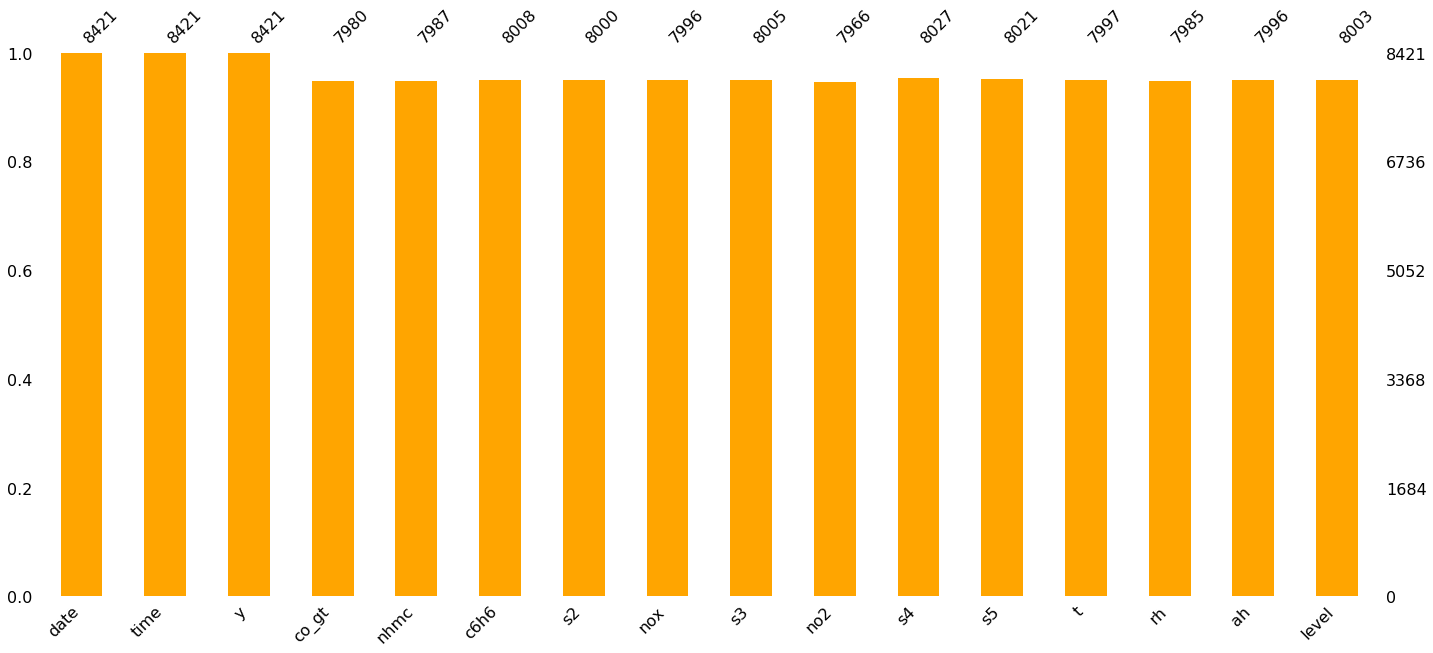

In [7]:
# Count number of value in each column
msn.bar(df, color="orange")

## Explore time series problem
Since this is a time series, I incorporate date time as the index and sort it out for an easier understanding

In [9]:
df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [10]:
df.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
Datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,3/10/2004,18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
2004-03-10 19:00:00,3/10/2004,19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2004-03-10 20:00:00,3/10/2004,20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
2004-03-10 21:00:00,3/10/2004,21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
2004-03-10 22:00:00,3/10/2004,22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


In [11]:
df.tail()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
Datetime,,,,,,,,,,,,,,,,
2005-02-24 10:00:00,2/24/2005,10:00:00,1178,2.7,-200.0,9.0,939.0,573.0,640.0,244.0,1228.0,NaN,4.1,83.9,0.6967,High
2005-02-24 11:00:00,2/24/2005,11:00:00,1093,1.8,NaN,6.5,836.0,414.0,728.0,232.0,1142.0,1025.0,NaN,82.0,0.6997,High
2005-02-24 12:00:00,2/24/2005,12:00:00,1060,1.4,-200.0,5.4,784.0,314.0,770.0,196.0,1117.0,941.0,5.5,79.5,0.7238,High
2005-02-24 13:00:00,2/24/2005,13:00:00,1121,1.7,-200.0,7.4,873.0,317.0,697.0,195.0,1206.0,1000.0,6.7,76.2,0.7519,High
2005-02-24 14:00:00,2/24/2005,14:00:00,1118,1.9,-200.0,NaN,888.0,290.0,685.0,189.0,1223.0,962.0,7.9,69.0,0.7394,High


#### Taking a look at each columns over time

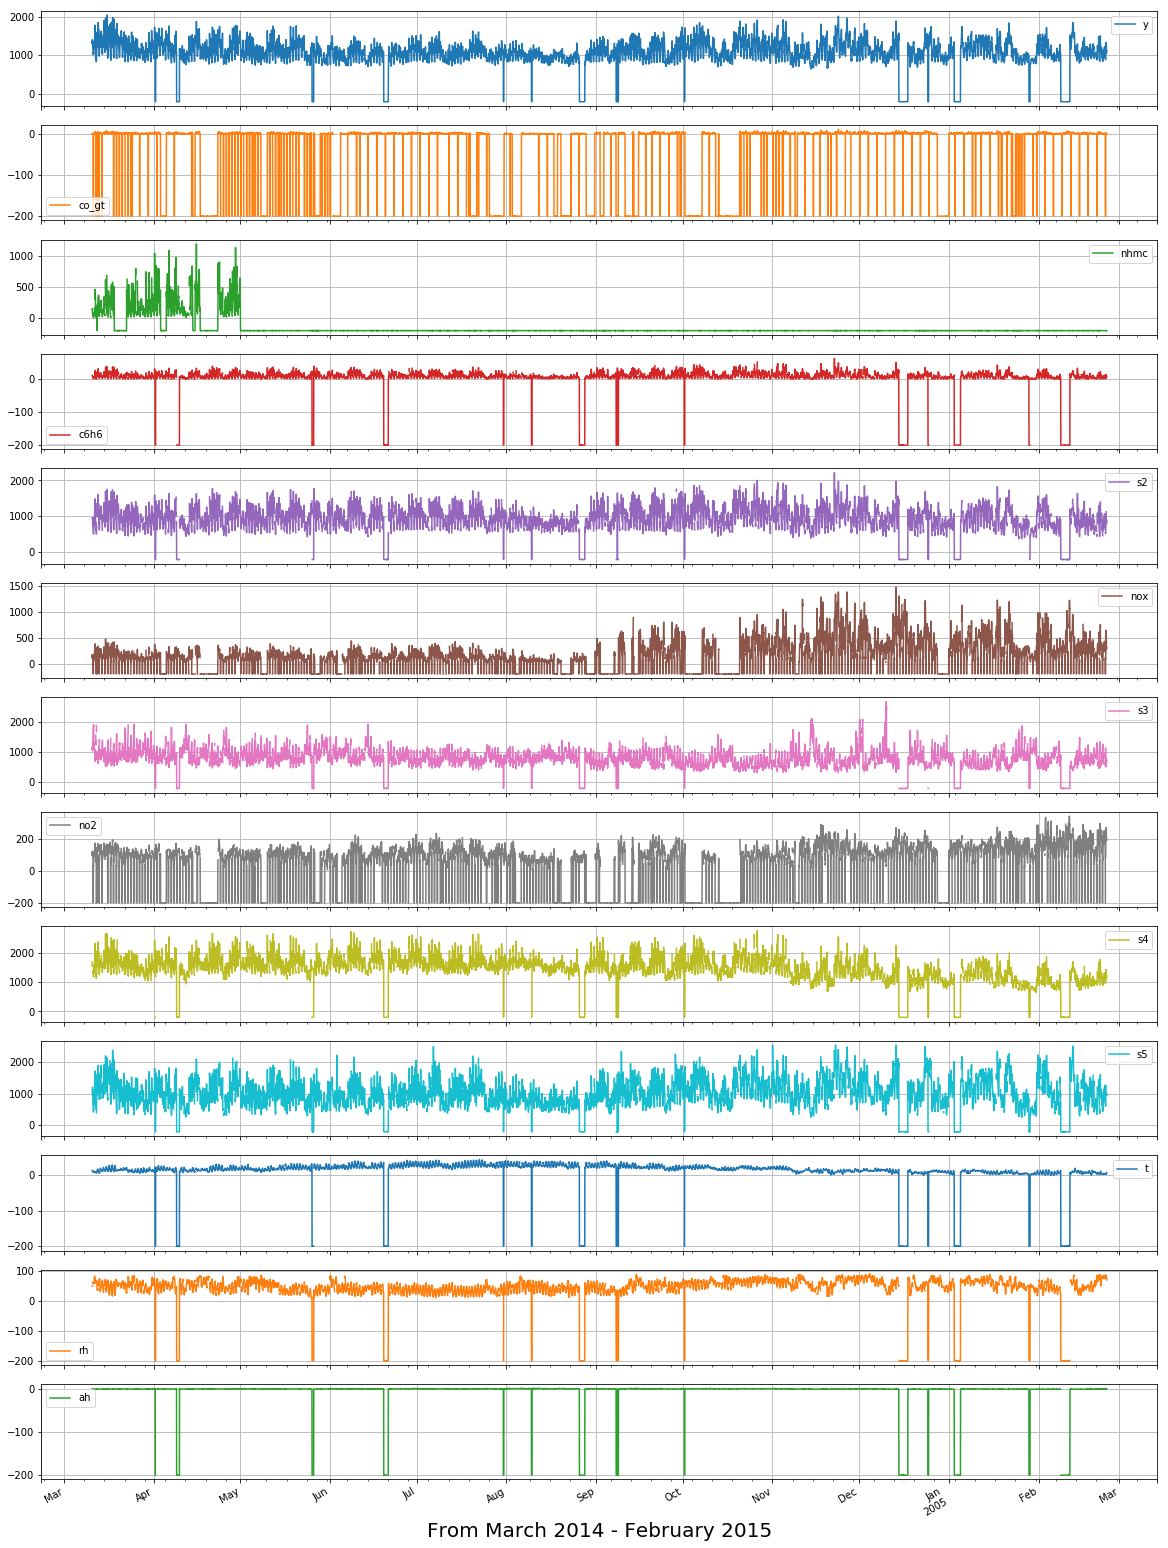

In [12]:
df.plot(figsize=(20,30), grid=True, subplots=True)
plt.xlabel('From March 2014 - February 2015', fontsize=20);

Seems like most of the features are stable over time and they have the same pattern for some particular time points of the year: their values drop to -200 or 0 at the same time. This maybe because the system was down or maintenance time. Currently, I still keep those value but for future exploration, I will exclude all these values. 

Another noted thing is feature `nhmc` has some very high, positive values from March to May 2014 and then drops to negative number and stays there till the end of observation time. I'm not sure how to deal with this yet. I'm keeping it but I don't think this feature should be included in.

A closer look at the city pollution over time:

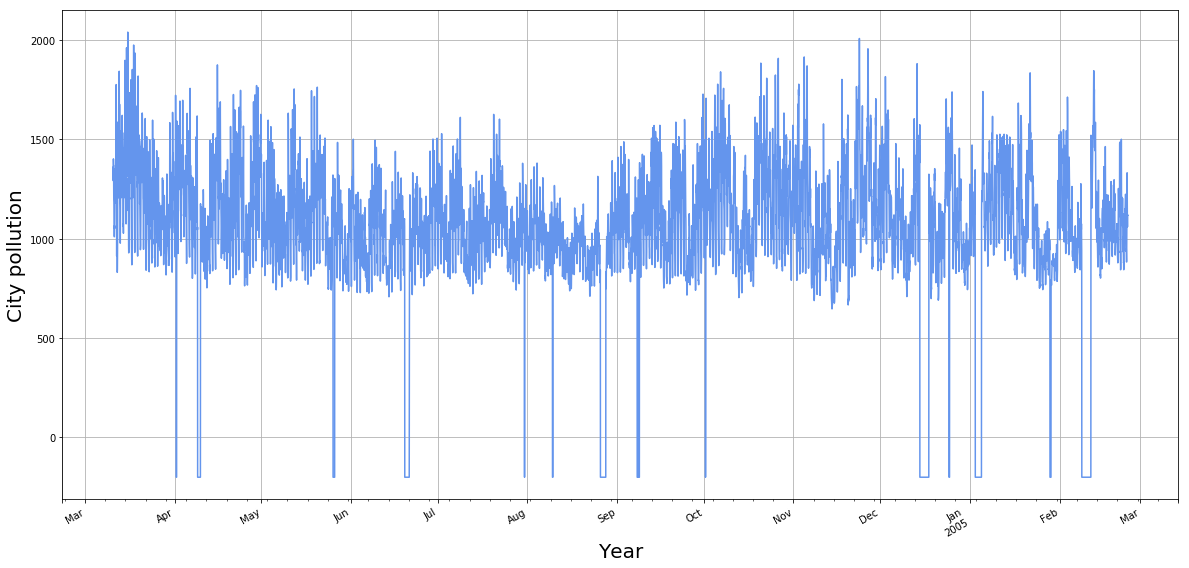

In [13]:
df['y'].plot(figsize=(20,10), grid=True, subplots=True, color="cornflowerblue")
plt.xlabel('Year', fontsize=20)
plt.ylabel('City pollution', fontsize=20);

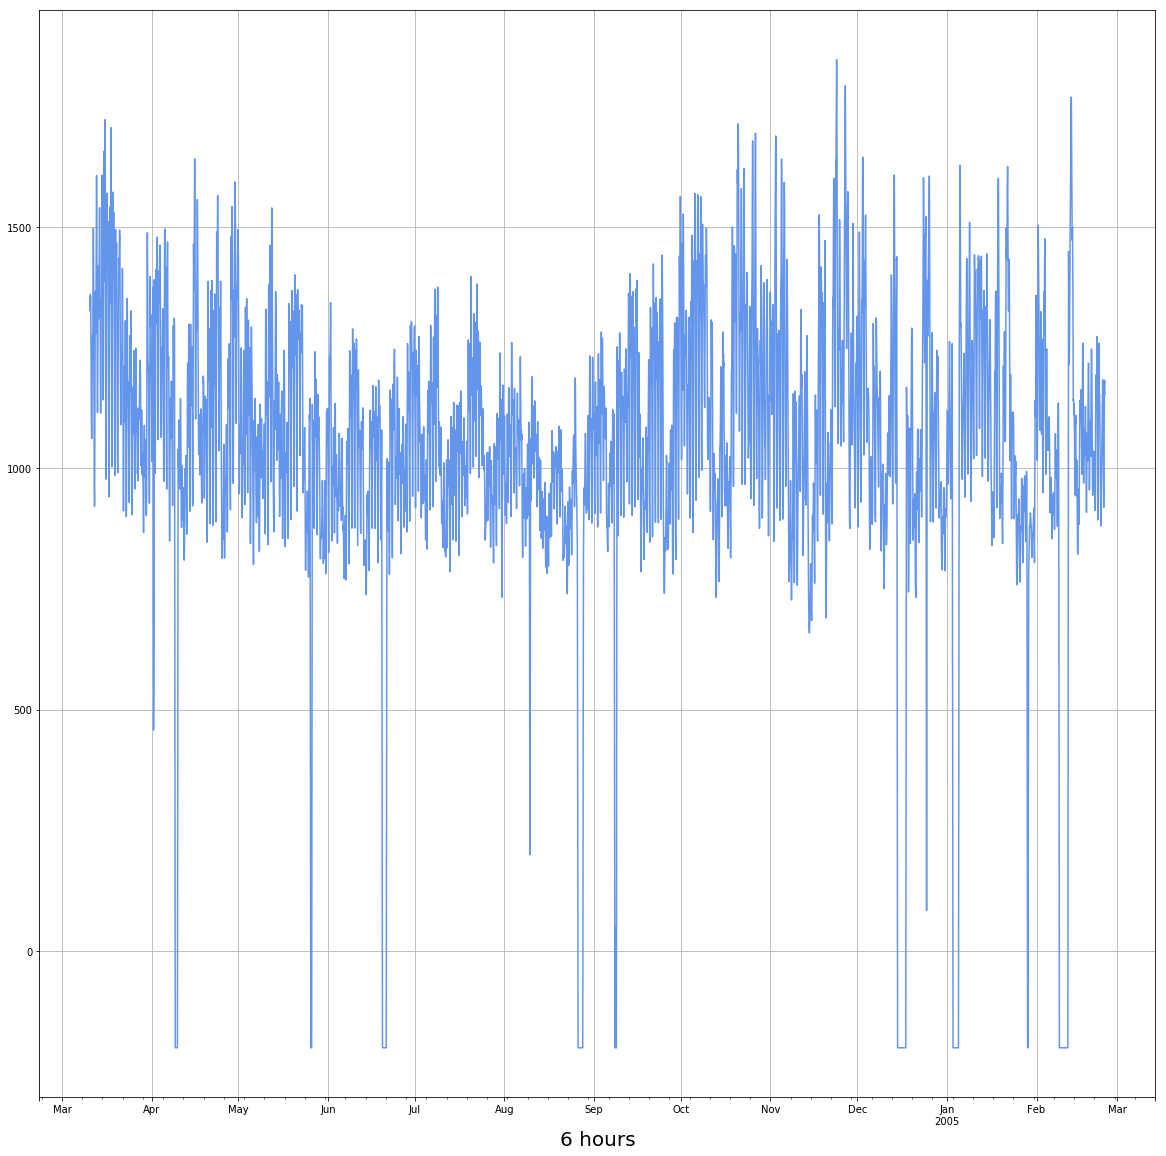

In [14]:
# Using rolling average with 6 hours window:
df['y'].rolling('6h').mean().plot(figsize=(20,20), fontsize=10, grid=True, color="cornflowerblue")
plt.xlabel('6 hours', fontsize=20);

In [15]:
# Time 
pollution = df.sort_values("y")

# Refactor the time_stamp column to datetime object
pollution["date"] = pd.to_datetime(df["date"])
pollution["time"] = pd.to_datetime(df["time"], format= '%H:%M:%S' ).dt.time

pollution = pollution.sort_values(["date","time"])

# Reset index
pollution = pollution.reset_index().iloc[:,1:29]
pollution.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10,18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10,19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10,20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10,21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10,22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


### Distribution of different levels of categorical variables:
There is only 1 categorical variable in the training data: level with 5 levels. Below is the imbalanced distribution of each level. 

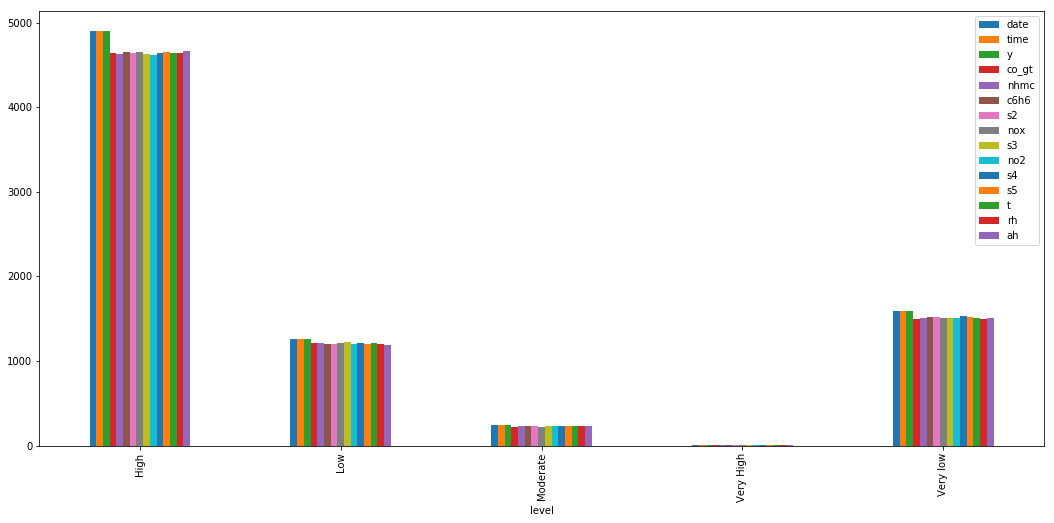

In [16]:
fig, ax = plt.subplots(figsize=(18,8))
pollution.groupby('level').count().plot(kind='bar', ax=ax)

In [17]:
# Create column contains value of 6 hours later:
pollution["y_shift"] = pollution[['time','y']]['y'].transform(lambda g: g.shift(periods=-6))

In [18]:
pollution[['date','time','y',"y_shift"]].head(10)

,date,time,y,y_shift
0,2004-03-10,18:00:00,1360,1185.0
1,2004-03-10,19:00:00,1292,1136.0
2,2004-03-10,20:00:00,1402,1094.0
3,2004-03-10,21:00:00,1376,1010.0
4,2004-03-10,22:00:00,1272,1011.0
5,2004-03-10,23:00:00,1197,1066.0
6,2004-03-11,00:00:00,1185,1052.0
7,2004-03-11,01:00:00,1136,1144.0
8,2004-03-11,02:00:00,1094,1333.0
9,2004-03-11,03:00:00,1010,1351.0


In [19]:
#Drop last 6 rows:
pollution.drop(pollution.tail(6).index,inplace=True)
pollution[['date','time','y',"y_shift"]].tail(10)

,date,time,y,y_shift
8405,2005-02-23,23:00:00,1016,883.0
8406,2005-02-24,00:00:00,1018,968.0
8407,2005-02-24,01:00:00,937,1071.0
8408,2005-02-24,02:00:00,949,1310.0
8409,2005-02-24,03:00:00,895,1332.0
8410,2005-02-24,04:00:00,884,1178.0
8411,2005-02-24,05:00:00,883,1093.0
8412,2005-02-24,06:00:00,968,1060.0
8413,2005-02-24,07:00:00,1071,1121.0
8414,2005-02-24,08:00:00,1310,1118.0


## Modelling
For time series, I can't use `train_test_split()`. So similar to task 1 I split by time. In this task however, I wrote a function to split using a threshold. 
For example if the threshold is 10%. First, I order by time line and then taking the last 10% obs as validation, next last 20% as test and the rest is for training. 

In [20]:
# Create a list of features needed
X_col = [ i for i in pollution.columns if i not in ['date', 'time', 'y_shift', 'y']]

In [21]:
# Create X, y
X = pollution[X_col]
y = pollution["y_shift"] # keeping time_stamp to split train test validation

In [22]:
# Split Train, Test, Validation set
Xval, Xtest, Xtrain, yval, ytest, ytrain = split_train_test_val(X, y, threshold=0.1)

### Creating pipeline and using several base regression model

The pipeline includes:
- **Subset**: taking only columns that will be in the train data. This function is to prevent there are some features appears in test set that was not in training.
- **Get_dummies**: Transform categorical data into dummies variables
- **Impute**: Impute all missing value (NaN) using mean. I chose not to drop na like in task 1 because the number of observation in this task is much less than in task 1.
- **Model**: Using base model from scikit learn library: 
    - Ridge Regression: Linear least squares with l2 regularization.
    - Lasso Regression: Linear least squares with l1 regularization.
    - Elastic Net: Linear regression with combined L1 and L2 priors as regularizer.

In [23]:
# Fitting several models to find which one would be good:
model_list = {"Ridge Regression": Ridge(),
              "Lasso": Lasso(),
              "Elastic Net": ElasticNet(),
              "Support Vector Regression": SVR()
             }

for k, v in model_list.items():
    print("Fitting {} model...".format(k))
    pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('model', v)
    ])
    pl.fit(Xtrain, ytrain)
    ypred = pl.predict(Xtest)
    print("R squared score is:", r2_score(ytest,ypred).round(3))

Fitting Ridge Regression model...
R squared score is: 0.522
Fitting Lasso model...
R squared score is: 0.522
Fitting Elastic Net model...
R squared score is: 0.521
Fitting Support Vector Regression model...
R squared score is: -0.024


### Ordinary Least Square

In [24]:
# Import the statsmodels module
import statsmodels.api as sm

pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0))
    ])

Xtrain_new = pl.fit_transform(Xtrain)

# Fit the regression of y on x
result = sm.OLS(ytrain,Xtrain_new).fit()

# Print out the results 
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                y_shift   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     6876.
Date:                Mon, 23 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:03:37   Log-Likelihood:                -46928.
No. Observations:                6733   AIC:                         9.389e+04
Df Residuals:                    6716   BIC:                         9.401e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3000      0.122     -2.467      0.0

In [25]:
Xtest_new = pl.fit_transform(Xtest)

ypred = result.predict(Xtest_new)

print("R squared score is:", r2_score(ytest,ypred).round(3))

R squared score is: 0.473


The R squared scored drop by half showing that the OLS may learn too much noise from the training dataset, making it a bad model.

### Keras Neural Network

In [27]:
from time import time 
# Using TensorBoard to track on accuracy/ loss and each steps inside Keras model.
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [28]:
# Using pipeline with Keras model:
estimator = KerasRegressor(build_fn=keras_model, epochs=10, batch_size=5, verbose=1, callbacks=[tensorboard])

pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),    
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)), 
        ('model', estimator)
    ])
pl.fit(Xtrain, ytrain.values.reshape(-1,1))
ypred = pl.predict(Xtest)
print("R squared score is:", r2_score(ytest,ypred).round(3))

Epoch 1/10
6733/6733 [==============================] - 6s 847us/step - loss: 499666.4877 - acc: 8.9113e-04
Epoch 2/10
6733/6733 [==============================] - 5s 766us/step - loss: 88306.9331 - acc: 0.0028
Epoch 3/10
6733/6733 [==============================] - 6s 824us/step - loss: 79762.2243 - acc: 7.4261e-04
Epoch 4/10
6733/6733 [==============================] - 5s 766us/step - loss: 77698.4116 - acc: 0.0018
Epoch 5/10
6733/6733 [==============================] - 5s 729us/step - loss: 75487.5670 - acc: 0.0015
Epoch 6/10
6733/6733 [==============================] - 5s 750us/step - loss: 74618.3819 - acc: 0.0024
Epoch 7/10
6733/6733 [==============================] - 5s 738us/step - loss: 74260.8478 - acc: 0.0016
Epoch 8/10
6733/6733 [==============================] - 5s 745us/step - loss: 73662.0570 - acc: 0.0033
Epoch 9/10
6733/6733 [==============================] - 5s 742us/step - loss: 73470.2417 - acc: 0.0027
Epoch 10/10
841/841 [==============================] - 0s 279us/

After several network configuration, the r squared score is still smaller than base model of Ridge and Lasso.
For more exploration using Neural Network, please take a look at the [Notebook](../../doc/Notebook.md)

### Conclusion
So the best model seems to be Ridge/ Lasso Regression. However, I cannot get pickle the Ridge Regression inside pipeline while Lasso works fine. Final work are:
- Rerun the whole pipeline
- Plotting residual plot to see if the residual is random or following a trend
- If residual plot looks fine, run pipeline again with the whole training data
- Pickle the model.

In [29]:
# Getting Pipeline ready and save model
pl = Pipeline([
    ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
    ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
    ('impute', Imputer(missing_values='NaN',
                        strategy="mean",
                        axis=0)),
    ('model', Lasso())
])
pl.fit(Xtrain, ytrain)
ypred = pl.predict(Xtest)
print("R squared score is:", r2_score(ytest,ypred).round(3))

R squared score is: 0.52


### Looking at the residual to verify

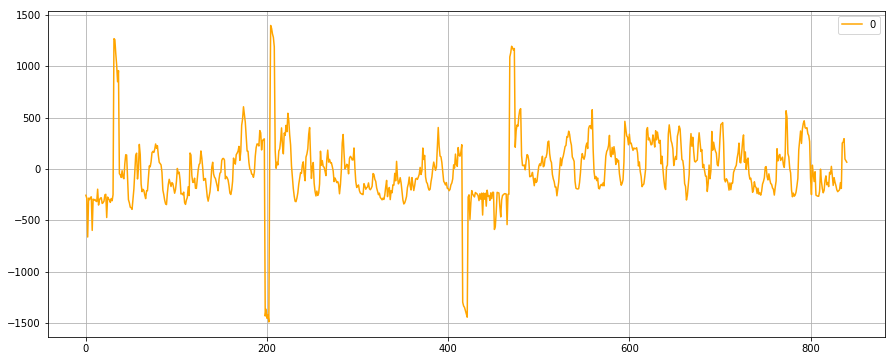

In [30]:
# reset index
ytest_new=ytest.reset_index(drop=True)
# calculate residuals
residuals = pd.DataFrame([ytest_new[i]-ypred[i] for i in range(len(ytest_new))])
residuals.plot(color="orange", grid=True);

This seems good with the residual running around 0 and does not following any trend. Now I will check with validation set.

In [31]:
# Check with validation
ypred = pl.predict(Xval)
print("R squared score is:", r2_score(yval,ypred).round(3))

R squared score is: 0.609


Much better score than with test data. This means the model did not learn noise from previous dataset. I will now train with the whole training data that I have and pickle the model

In [32]:
# Getting Pipeline ready and save model
pl = Pipeline([
    ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
    ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
    ('impute', Imputer(missing_values='NaN',
                        strategy="mean",
                        axis=0)),
    ('model', Lasso())
])
pl.fit(X, y)

Pipeline(memory=None,
     steps=[('get_dummie', FunctionTransformer(accept_sparse=False,
          func=<function get_dummies at 0x0000019776031E18>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('subset', FunctionTransformer(accept_sparse=False,
          func...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [34]:
# Save the pipeline:
joblib.dump(pl, '../../results/task2_model.pkl')

['../../results/task2_model.pkl']